<a href="https://colab.research.google.com/github/Chrisvanhoorn/BioAI/blob/main/Notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notes for BioAI Technical Test**




This file contains the notes and considerations for the assignment.

# Assignment

Build a protein classifier. For each given protein, assign the corresponding pfam family.

# Dataset analysis

## Balanced dataset
First check if the dataset is balanced and has proper representation in each class.

**Is each class (family_accession) equally represented in the dataset?**

In [2]:
#read data

import os
import pandas as pd

data_path = '/content/drive/My Drive/Colab Notebooks/random_split'


# combine separate CSVs per folder
def read_data(split, data_folder=data_path):
    data = []  #
    for filename in os.listdir(os.path.join(data_folder, split)):
        with open(os.path.join(data_folder, split, filename)) as f:
            data.append(pd.read_csv(f, index_col=None))
    return pd.concat(data)


# three split folders
df_train = read_data('train')
df_val = read_data('dev')
df_test = read_data('test')

# data frame looks like:
df_train.head()

,family_id,sequence_name,family_accession,aligned_sequence,sequence
0,MORN_2,Q8EI47_SHEON/428-449,PF07661.13,LHGEFRNQTSSGQLLELI.NFNH,LHGEFRNQTSSGQLLELINFNH
1,Plexin_cytopl,H2TB23_TAKRU/1240-1793,PF08337.12,.MPFLDYKTYTDCNFFLPSKDGAND......AMITRKLQIPE.......,MPFLDYKTYTDCNFFLPSKDGANDAMITRKLQIPEARRAIVAQALN...
2,RT_RNaseH,H3H8E9_PHYRM/405-501,PF17917.1,DYSRRFHVFADAS.GH.QIGGVIVQ........................,DYSRRFHVFADASGHQIGGVIVQGRRILACFSRSMTDTQKKYSTME...
3,Transposase_20,Q981X5_RHILO/224-313,PF02371.16,VEAYQAMRGASFLVAVIFAAEI.GDV.RR.FDTPPQLMAFLGLVPG...,VEAYQAMRGASFLVAVIFAAEIGDVRRFDTPPQLMAFLGLVPGERS...
4,Mycobact_memb,MMPS4_MYCLE/16-154,PF05423.13,LSRIWIPLVILVVLVVGGFVVYRVHSYFASEKRESYADSNLGSSKP...,LSRIWIPLVILVVLVVGGFVVYRVHSYFASEKRESYADSNLGSSKP...


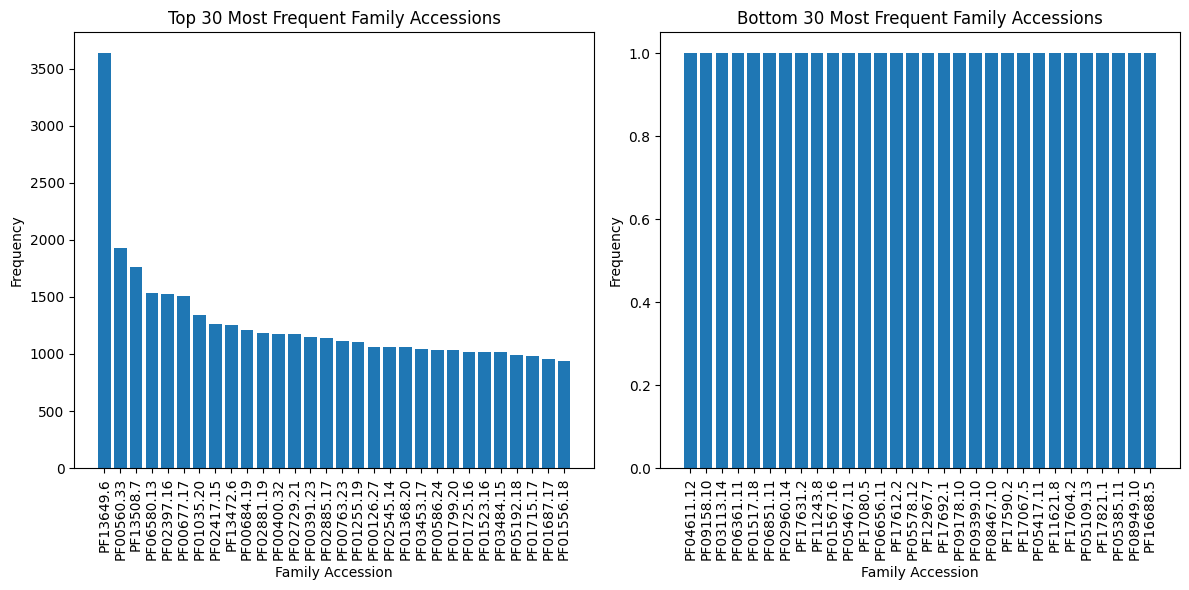


 Number of family_accessions with only one sequence: 507


In [44]:
import matplotlib.pyplot as plt

# Count family occurrences
def fam_occupancy(df):
    fam_freq = df['family_accession'].value_counts().reset_index()  # Use column name
    fam_freq.columns = ["family_accession", "Frequency"]
    return fam_freq

# Plot the top and bottom n sorted frequency of family accessions
# If not done, you can't judge what numbers the bars correspond to
def plot_top_bottom_families(df, top_n):
  fig, axes = plt.subplots(1, 2, figsize=(12, 6))

  # Plot top n family accessions
  df_top = df.head(top_n)
  axes[0].bar(df_top['family_accession'], df_top['Frequency'])
  axes[0].set_title(f'Top {top_n} Most Frequent Family Accessions')
  axes[0].set_xlabel('Family Accession')
  axes[0].set_ylabel('Frequency')
  axes[0].tick_params(axis='x', rotation=90)

  # Plot bottom n family accessions
  df_bottom = df.tail(top_n)
  axes[1].bar(df_bottom['family_accession'], df_bottom['Frequency'])
  axes[1].set_title(f'Bottom {top_n} Most Frequent Family Accessions')
  axes[1].set_xlabel('Family Accession')
  axes[1].set_ylabel('Frequency')
  axes[1].tick_params(axis='x', rotation=90)

  plt.tight_layout()
  plt.show()

# Calculate family occupancy
fam_occupancy_train = fam_occupancy(df_train)

# Plot top and bottom "n"-number of family accessions
plot_top_bottom_families(fam_occupancy_train, top_n=30)

single_occurrence_count = (fam_occupancy_train['Frequency'] == 1).sum()
print("\n Number of family_accessions with only one sequence:", single_occurrence_count)



There are 507 families that have only a single sequence: The dataset is unbalanced. This needs to be taken into account when training the classification to avoid overfitting.

Another issue is that the dev and test data are only 10% of the data each. so in close loop validation, the single-occurrence classes will not all be represented, making it even more prone to overfitting.

%if time, check if there are families unique to test and dev data splits.

## Rare amino acids

Rare and ambiguous amino acids may have different weight in the classification. Check if the amino acids are present frequently, and if they are present only in a few classes.

**Check the amino acid frequency**

In [8]:
#count AA occurrence

from collections import defaultdict

def AA_freq(df):
  # concatenates sequence strings with spaces, no splitting later
  AA_all = df.str.cat(sep=" ")

  # AAs, for sequences in df, loop for each AA in sequence
  AA_list = [AA for sequence in df for AA in sequence]

  # Use dictonary for AA counts
  AA_dict = defaultdict(int)
  for AA in AA_list:
    if AA != ' ':  # Exclude spaces
      AA_dict[AA] += 1

  #print the frequencies, descending
  AA_freq = pd.DataFrame(list(AA_dict.items()), columns=["AA", "Frequency"])
  AA_freq = AA_freq.sort_values("Frequency", ascending=False)
  AA_freq = AA_freq.reset_index(drop=True)

  print(AA_freq)
  return(AA_freq)

# sort and check AAs in training dataset
AA_frequency_train = AA_freq(df_train['sequence'])


   AA  Frequency
0   L   17062816
1   A   14384873
2   V   11913147
3   G   11845579
4   E   10859966
5   S   10597822
6   I   10234455
7   R    9406165
8   D    9371097
9   K    9127832
10  T    9034110
11  P    7441084
12  F    7130287
13  N    6616976
14  Q    6250389
15  Y    5556597
16  M    3708948
17  H    3704587
18  C    2316115
19  W    2293257
20  X       1505
21  U        119
22  B         33
23  O         18
24  Z          8


Some amino acids are not frequent. I want to check their distribution over sequences and families to see if they may contribute to potential overfitting.

**check if some AAs are overrepresented in family_accessions.**


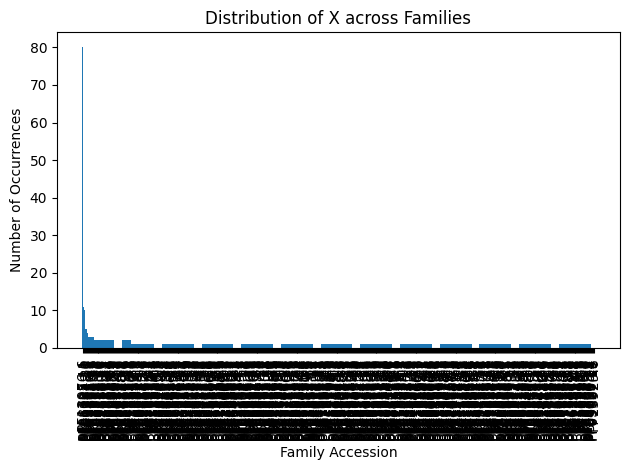

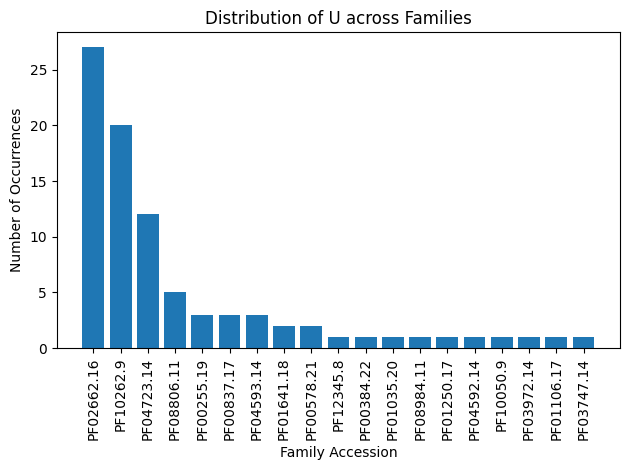

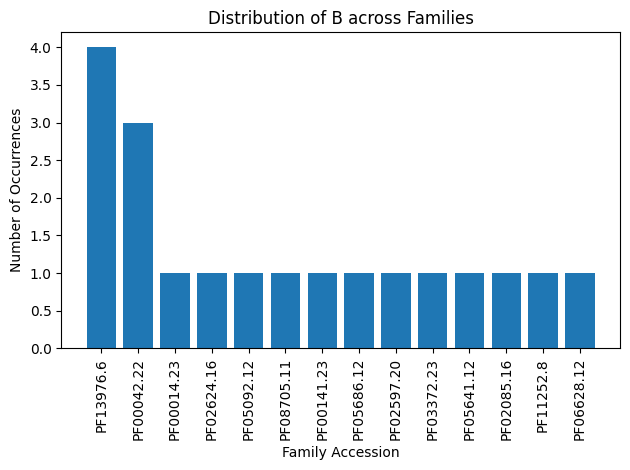

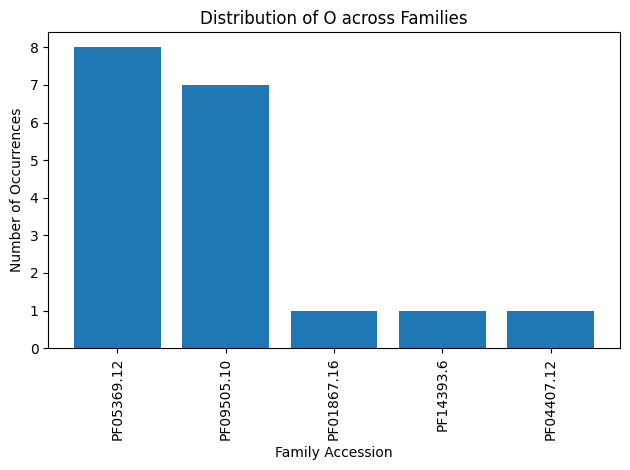

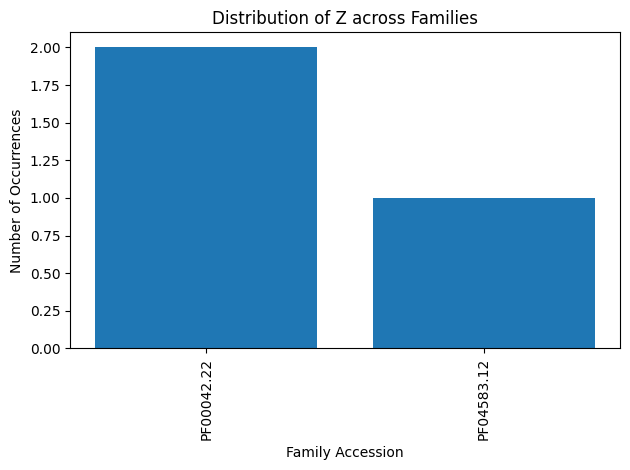

In [41]:
# Analyze the distribution of low-frequency amino acids across family accessions.

def analyze_low_freq_aa(aa_freq_df, fam_occupancy_df, top_n_rare=5):
  # Get the least frequent amino acids
  rare_aas = aa_freq_df.tail(top_n_rare)['AA'].tolist()

  # Iterate over rare amino acids
  for aa in rare_aas:
    # Filter sequences containing the rare amino acid
    sequences_with_aa = df_train[df_train['sequence'].str.contains(aa)]

    # Count occurrences of the amino acid in each family
    aa_counts_per_family = sequences_with_aa['family_accession'].value_counts()

    # Plot bar chart for all families containing the amino acid
    plt.figure()
    plt.bar(aa_counts_per_family.index, aa_counts_per_family.values)
    plt.title(f'Distribution of {aa} across Families')
    plt.xlabel('Family Accession')
    plt.ylabel('Number of Occurrences')
    plt.xticks(rotation=90)  # Rotate x-axis labels for readability
    plt.tight_layout()
    plt.show()

# Analyze distribution of 5 least frequent amino acids
analyze_low_freq_aa(AA_frequency_train, fam_occupancy_train)

I think this is balanced enough. There is one family with the most X (any AA) present. I want to check the sequences with the highest proportion of X. If these sequences are predominantly composed of X I will discard them.  

I'll also check if the family accessions where Z is found (PF04583.12 and PF00042.22) have multiple sequences so it will not overfit based on the presence of this residue.

**find proportion of X for sequences with the highest proportion.**

In [34]:
# Analyze the proportion of 'X' in sequences and give highest percentages
def analyze_x_proportion(df, top_n):
    df['X_percentage'] = df['sequence'].apply(lambda seq: seq.count('X') / len(seq) * 100)
    top_x_sequences = df.sort_values('X_percentage', ascending=False).head(top_n)

    print(top_x_sequences[['family_accession', 'X_proportion']])
    return top_x_sequences

def sequences_per_family(df, family_accessions):
    counts = df['family_accession'].value_counts()
    accession_counts = {accession: counts.get(accession, 0) for accession in family_accessions}
    print("\nsequences per family_accession")
    print(accession_counts)

top_sequences = analyze_x_proportion(df_train, top_n=5)
family_counts = sequences_per_family(df_train, family_accessions=['PF04583.12', 'PF00042.22'])
family_counts = sequences_per_family(df_train, family_accessions=['PF04583.12', 'PF00042.22'])

      family_accession  X_proportion
6775        PF04714.13      0.229167
7126        PF08705.11      0.184211
2958        PF08705.11      0.157895
12009        PF12191.8      0.157025
12780        PF16058.5      0.150000

sequences per family_accession
{'PF04583.12': 8, 'PF00042.22': 59}


There is no sequence that has such a high X occurrence that it should be excluded.

The families in which ambiguous amino acid Z is present also have plenty of sequences with no Z's in them. I worry less about overfitting here.

##Sequence length
Sequence length is variable. check lenghth distribution and check the length of the shortest and longest sequences.

**check length distribution**


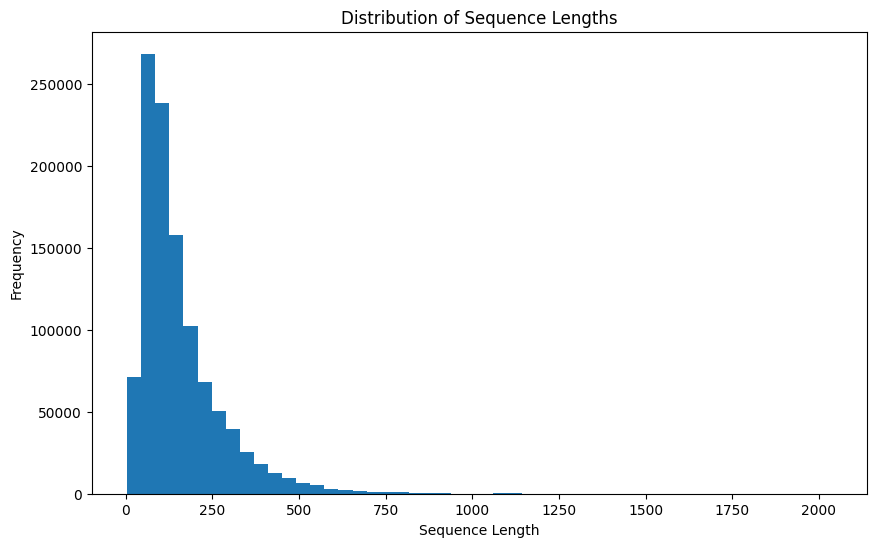

Shortest sequence length: 4
Longest sequence length: 2037

Families with ONLY short sequences and less than 5 total sequences:
PF00220.17
PF00446.17
PF03373.14
PF08257.11
PF08258.11
PF08260.11
PF08261.12
PF08262.11


In [54]:
import matplotlib.pyplot as plt

def analyze_sequence_lengths(df, short_sequence_threshold = 10, max_total_sequences = 5):
    # Calculate sequence lengths
    df['sequence_length'] = df['sequence'].apply(len)

    # Plot length distribution
    plt.figure(figsize=(10, 6))
    plt.hist(df['sequence_length'], bins=50)
    plt.xlabel('Sequence Length')
    plt.ylabel('Frequency')
    plt.title('Distribution of Sequence Lengths')
    plt.show()

    # Print shortest and longest sequence lengths
    shortest_length = df['sequence_length'].min()
    longest_length = df['sequence_length'].max()
    print(f"Shortest sequence length: {shortest_length}")
    print(f"Longest sequence length: {longest_length}")

    # Identify families with ONLY short sequences and less than max_total_sequences
    # Group by family and get length counts for each
    family_length_counts = df.groupby('family_accession')['sequence_length'].agg(['count', 'max'])

    # Filter for families meeting the criteria
    exclusive_short_families = family_length_counts[
        (family_length_counts['max'] <= short_sequence_threshold) &
        (family_length_counts['count'] < max_total_sequences)
    ]

    if not exclusive_short_families.empty:
        print("\nFamilies with ONLY short sequences and less than 5 total sequences:")
        for family, _ in exclusive_short_families.iterrows():
            print(family)
    else:
        print("\nNo families found with ONLY short sequences and less than 5 total sequences.")

# Example usage
analyze_sequence_lengths(df_train)  # Replace df_train with your DataFrame

I will have to check if the neural network is able to correctly classify proteins to the families with only short proteins. There is very little data there.

# Method explanation

## choice of algorithm.

Given the nature and statistics of the dataset, I took into account the following considerations:

### long range and short range dependency

Motifs (sets of conserved AAs) are important and are characteristics for a class. The classification requires capturing short-range dependencies as well as long range dependencies based on the importance of:

- Their presence or absence. (short-range)

- Co-occurence of multiple motifs. (short-range)

- Relative position of motifs. (long-range)

- Spacing between motifs. Likely not their exact position, unless this alters the structure. (long-range)

Within motifs, the physical properties of AAs are important. This also requires a network with strong long-range and short-range dependencies.

- AAs may change to an AA with similar properties. results in similar function (i.e. same family). (short-range)

- AAs may change so properties of that position change. The sequence ends up in a different family/functional group. (short-range)

- AA position may change properties while an interacting motifs (within the same domain) may have co-evolved, having retained the domain function (change didn't affect class). (long-range)

- AAs may change properties but interacting motifs (in a different domain) may have complementary co-evolved, having retained the interaction between the motifs (retained in same families). (proper weighting of contributions)

- AAs may change properties but interacting motifs (in a different domain) may have co-evolved, having both lost their domain function (change affected classes). (proper weighting of contributions)

### Type of Network
to capture the long and short-range dependencies a CNN in combination with an RNN. However, since some of the sequences are very long an RNN may struggle to run on a laptop (one of the requirements of the assignment).

I considered a GNN, but there is no structural, evolutionary, or distance data given, or other information that could be represented in the edges.

I considered adding additional data to the input (i.e. an MSA or structure predictions which are often indirectly based on MSA) to provide more information on long range dependencies and evolutionary relationships. But this data was not given. Moreover, since some of the sequences are protein domains of protists/bacteria (Bileschi et al., 2019), I do not consider the alignments or MSAs very reliable because of less data available from such organisms. I would like to do a more agnostic approach with just the sequence text. Thus I chose to also not use the alignment information present in the dataset.

Ultimately I decided to use a DilatedCNN. This can capture both local and long-range dependencies while in general being less computationally intensive than Transformers and RNNs.

https://machinelearningmastery.com/when-to-use-mlp-cnn-and-rnn-neural-networks/
https://research.google/blog/using-deep-learning-to-annotate-the-protein-universe/
https://arxiv.org/abs/1511.07122

### data preparation

I considered, given the dataset (and not using the alignment MSA or structural predictions), what kind of input I could provide an algorithm:
- binary vectors (one-hot encoding), a 22-scalar long vector, filled with 0's apart from the scalar that corresponds to the AA, represented as a 1 (AA-X would contain all 0's. Z and B could be represented as 0.5-1 in two positions to represent their ambiguous assignment).
- property vectors, each scalar represents a property of the AA. This reduces the information present in the sequence and I won't do it for the current size of the dataset and imbalanced class distribution.
- feed the sequence directly and let it be embedded. For this I may have to do data augmentation and test as a separate train_dataset, or other methods to prevent overfitting.

I'm reading various different opinions on whether word embedding or hot coding is more favourable for this dataset with a large class imbalance and several long sequences. I will use word embedding because of the reduced dimensionality with the long sequences, and because it is a limited vocabulary.

https://datascience.stackexchange.com/questions/29851/one-hot-encoding-vs-word-embedding-when-to-choose-one-or-another
%read up more in primary literature and verify

#### considerations for rare amino acids.

I will treat the rarest AAs as their separate letters given that they are present in more than 1 classes that have multiple sequences that don't contain these AAs. I would like to try and reduce overfitting in other ways.
- O: Pyrrolysine (Pyl): could change to amino acid with similar properties Lysine (K) or Arginine (R) (positively charged), but will lose information.
- U: Selenocysteine (Sec): changing to structurally similar Cysteine (C), will also lose information.

- B: Asparagine (N) or Aspartic acid (D). They are similar in structure, but have different properties. Can be treated as a separate amino acid.
- Z: Glutamine (Q) or Glutamic acid (E). Both are similar in structure, but different properties. Could be treated as a separate amino acid.

- X: Any amino acid.

#### Data Augmentation for sequences with less than 4 examples
The augmentation strategy I list below would reduce it from being an agnostic approach. So I will generate a separate augmented dataset for training and compare it to the not-augmented dataset for performance.

- change AAs randomly for AAs.
- change AAs corresponding to the aligned sequence randomly with similar chem/physical properties.
- shuffle segments but don't break up parts of aligned stretches.
- randomly apply deletions and insertions in non-aligned parts.



In [58]:
import numpy as np
import jax
import jax.numpy as jnp
#flax
#optax


In [ ]:
#### Is not working yet
import pandas as pd

# Assuming your DataFrame is named 'df' and the sequence column is named 'sequence'
sequences = df_train['sequence'].tolist()
families = df_train['family_accession'].tolist()

# Define vocabulary and special tokens
vocab = {'A': 0, 'C': 1, 'D': 2, 'E': 3, 'F': 4, 'G': 5, 'H': 6, 'I': 7, 'K': 8, 'L': 9, 'M': 10, 'N': 11, 'P': 12, 'Q': 13, 'R': 14, 'S': 15, 'T': 16, 'V': 17, 'W': 18, 'Y': 19, 'B': 20, 'Z': 21, 'X': 22, 'U': 23, 'O': 24, '_PAD_': 25}
vocab_size = len(vocab)
pad_token = vocab['_PAD_']

# Create a dictionary to map family to class indices
family_map = {family: i for i, family in enumerate(set(families))}

# Convert sequences to numerical representations
def encode_sequence(seq):
  return jnp.array([vocab.get(aa, pad_token) for aa in seq])

encoded_sequences = [encode_sequence(seq) for seq in sequences]

# Convert family strings to class indices
encoded_families = jnp.array([family_map[family] for family in families])

# Pad sequences
max_length = max(len(seq) for seq in sequences)
padded_sequences = jnp.array([jnp.pad(seq, (0, max_length - len(seq)), constant_values=pad_token) for seq in encoded_sequences])

# Combine the padded sequences and encoded families into a dataset
dataset = [(seq, family) for seq, familiy in zip(padded_sequences, encoded_families)]


In [ ]:
#### Is not working yet

# Create embedding layer and initialize special tokens
class ProteinEmbedder(nn.Module):
    num_embeddings: int
    embedding_dim: int

    def setup(self):
        self.embedding = nn.Embed(num_embeddings=self.num_embeddings, features=self.embedding_dim)

    def __call__(self, inputs):
        embeddings = self.embedding(inputs)

        # Handle ambiguous amino acids in the embedding layer
        embeddings = embeddings.at[:, inputs == vocab['Z']].set((embeddings[:, inputs == vocab['Q']] + embeddings[:, inputs == vocab['E']]) / 2)
        embeddings = embeddings.at[:, inputs == vocab['B']].set((embeddings[:, inputs == vocab['N']] + embeddings[:, inputs == vocab['D']]) / 2)
        # Initialize X embeddings to the average of all other embeddings
        all_embeddings = embeddings[:, :20]  # Not counted 'B', 'Z', 'X', and '_PAD_'
        average_embedding = jnp.mean(all_embeddings, axis=1, keepdims=True)
        embeddings = embeddings.at[:, inputs == vocab['X']].set(average_embedding)

        return embeddings

embedding_layer = ProteinEmbedder(num_embeddings=vocab_size, embedding_dim=100)  #chose 100 as starting value. Increase if results are overfitted, and if theres time try different values.


In [ ]:
#Define CNN architecture with dilated convolutions


## Method Explanation

Consider keeping the kernel size constant and only increasing the dilation rate.
To capture increasingly larger patterns without reducing detail.


## Experiment Description

set of experiments in order to prove the advantage (if exists) of the proposed method

I will check if the neural network is able to correctly classify proteins to the families with only short proteins.

I will check if proteins from poorly represented classes are classified well.

I have to check if rare AAs don't overfit. I would check if the model (trained on this set or the entire pfam dataset) performs better than the models mentioned in Bileschi et al., 2019.

I would check if the results from Class Activation Maps make sense biologically, by comparing it to an MSA.

## Result Analysis

summarize & analyze

